# **Ajustes do DF**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('df_producao_total.csv', sep=',')
df.head()

,data,producao
0,1997-01-01,812324
1,1997-02-01,818768
2,1997-03-01,846938
3,1997-04-01,818238
4,1997-05-01,786930


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   data      343 non-null    object
 1   producao  343 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.5+ KB


In [ ]:
df["data"] = pd.to_datetime(df["data"], errors="coerce")
df["data"] = df["data"].dt.to_period("M").dt.to_timestamp()
df = df.set_index("data").sort_index()
print(df.head())
print(df.index.dtype)

            producao
data                
1997-01-01    812324
1997-02-01    818768
1997-03-01    846938
1997-04-01    818238
1997-05-01    786930
datetime64[ns]


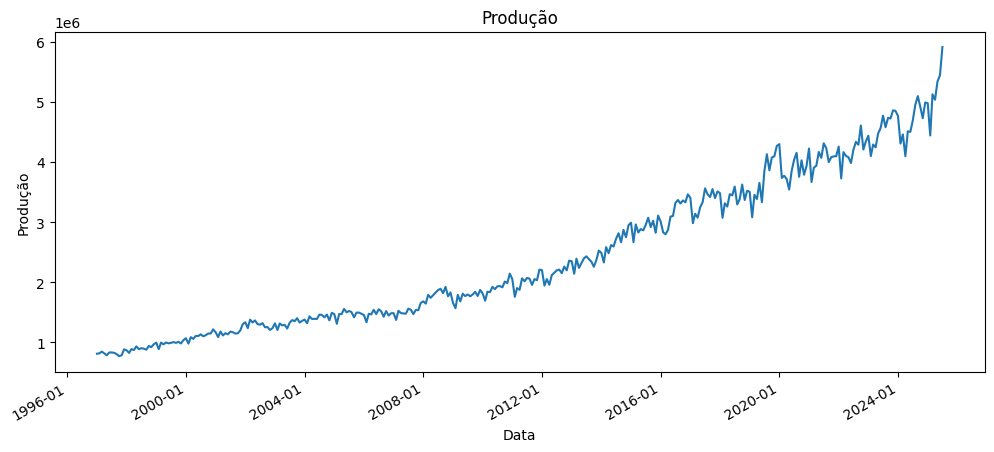

In [ ]:
import matplotlib.dates as mdates

plt.figure(figsize=(12,5))
plt.plot(df.index, df["producao"])

plt.title("Produção")
plt.xlabel("Data")
plt.ylabel("Produção")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate()

plt.show()

In [ ]:
ts = df['producao']
ts['2004-05-01']

np.int64(1392775)

In [ ]:
ts['2004-05':'2004-12']

,producao
data,
2004-05-01,1392775
2004-06-01,1390781
2004-07-01,1463457
2004-08-01,1457531
2004-09-01,1417593
2004-10-01,1464051
2004-11-01,1366916
2004-12-01,1492926


# **Decomposição**

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
decomposicao = seasonal_decompose(ts, period=12)

In [ ]:
tendencia = decomposicao.trend

In [ ]:
#sozonalidade
sazonal = decomposicao.seasonal

In [ ]:
#erro
aleatorio = decomposicao.resid

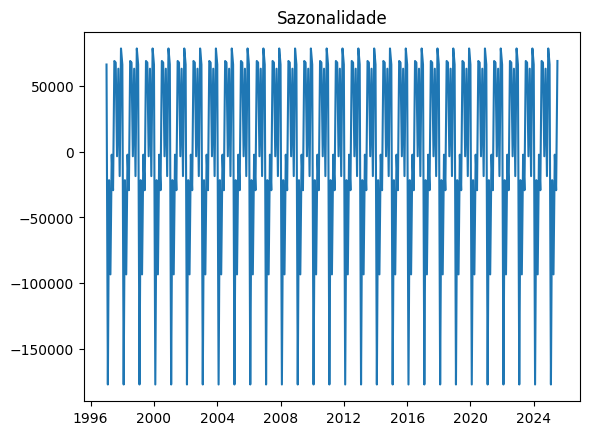

In [ ]:
plt.plot(sazonal)
plt.title('Sazonalidade')
plt.show()

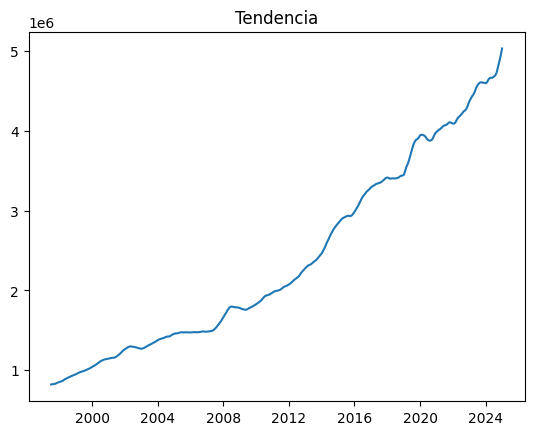

In [ ]:
plt.plot(tendencia)
plt.title('Tendencia')
plt.show()

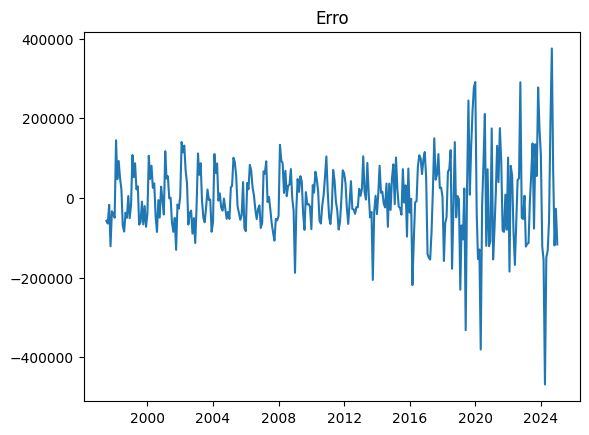

In [ ]:
plt.plot(aleatorio)
plt.title('Erro')
plt.show()

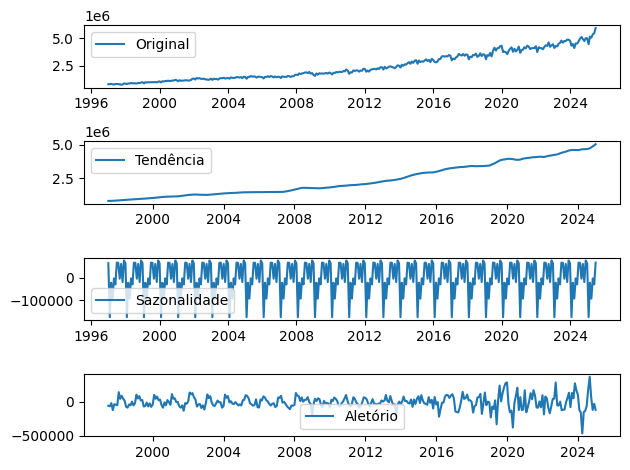

In [ ]:
plt.subplot(4,1,1)
plt.plot(ts, label = 'Original')
plt.legend(loc = 'best')

# Visualização somente da tendência
plt.subplot(4,1,2)
plt.plot(tendencia, label = 'Tendência')
plt.legend(loc = 'best')

# Visualização somente da sazonalidade
plt.subplot(4,1,3)
plt.plot(sazonal, label = 'Sazonalidade')
plt.legend(loc = 'best')

# Visualização somente do elemento aleatório
plt.subplot(4,1,4)
plt.plot(aleatorio, label = 'Aletório')
plt.legend(loc = 'best')
plt.tight_layout()

# **Holt Winters**

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
#separate train/validation
train, val, test = ts['1997-01':'2021-12'], ts['2022-01':'2023-12'], ts['2024-01':]

In [ ]:
#aditivo e multiplicativo
m = 12
models = {}
for seasonal in ['add', 'mul']:
    model = ExponentialSmoothing(
        train, trend='add', seasonal=seasonal, seasonal_periods=m
    ).fit()
    forecast_val = model.forecast(len(val))
    mae_val = mean_absolute_error(val, forecast_val)
    rmse_val = np.sqrt(mean_squared_error(val, forecast_val))
    mape_val = np.mean(np.abs((val - forecast_val) / val)) * 100
    models[seasonal] = {'model': model, 'forecast_val': forecast_val, 'mae_val': mae_val, 'rmse_val': rmse_val, 'mape_val': mape_val}
    print(f"{seasonal} -> MAE na validação: {mae_val:.2f}")
    print(f"{seasonal} -> RMSE na validação: {rmse_val:.2f}")
    print(f"{seasonal} -> MAPE na validação: {mape_val:.2f}%")

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


add -> MAE na validação: 216365.00
add -> RMSE na validação: 265644.22
add -> MAPE na validação: 4.79%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


mul -> MAE na validação: 241386.90
mul -> RMSE na validação: 293769.22
mul -> MAPE na validação: 5.34%


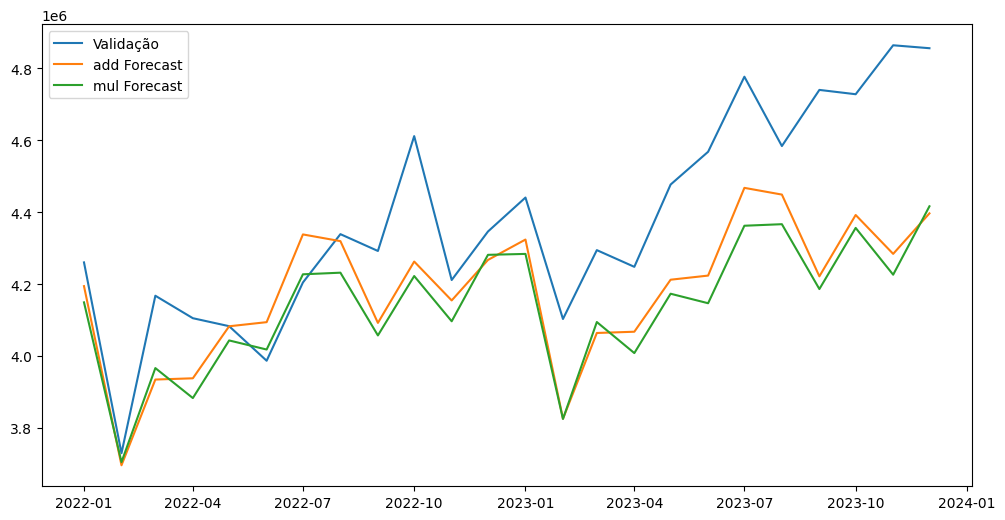

In [ ]:
#plot dos dois modelos
plt.figure(figsize=(12, 6))
plt.plot(val.index, val, label='Validação')
for seasonal in ['add', 'mul']:
    plt.plot(val.index, models[seasonal]['forecast_val'], label=f'{seasonal} Forecast')
plt.legend()
plt.show()

In [ ]:
best_seasonal = min(models, key=lambda k: models[k]['mae_val'])
print(f"Melhor modelo pela validação: {best_seasonal}")

Melhor modelo pela validação: add


**Modelo Final**

In [25]:
final_train = ts['1997-01':'2023-12']
final_model_holtwinters = ExponentialSmoothing(
    final_train, trend='add', seasonal=best_seasonal, seasonal_periods=m
).fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [26]:
forecast_test = final_model_holtwinters.forecast(len(test))
mae_test = mean_absolute_error(test, forecast_test)
rmse_test = np.sqrt(mean_squared_error(test, forecast_test))
mape_test = np.mean(np.abs((test - forecast_test) / test)) * 100
accuracy = 100 - mape_test
print(f"Erro final no teste: {mae_test:.2f}")
print(f"RMSE final no teste: {rmse_test:.2f}")
print(f"MAPE final no teste: {mape_test:.2f}%")
print(f"Acurácia final no teste: {accuracy:.2f}%")

Erro final no teste: 266370.55
RMSE final no teste: 317440.48
MAPE final no teste: 5.49%
Acurácia final no teste: 94.51%


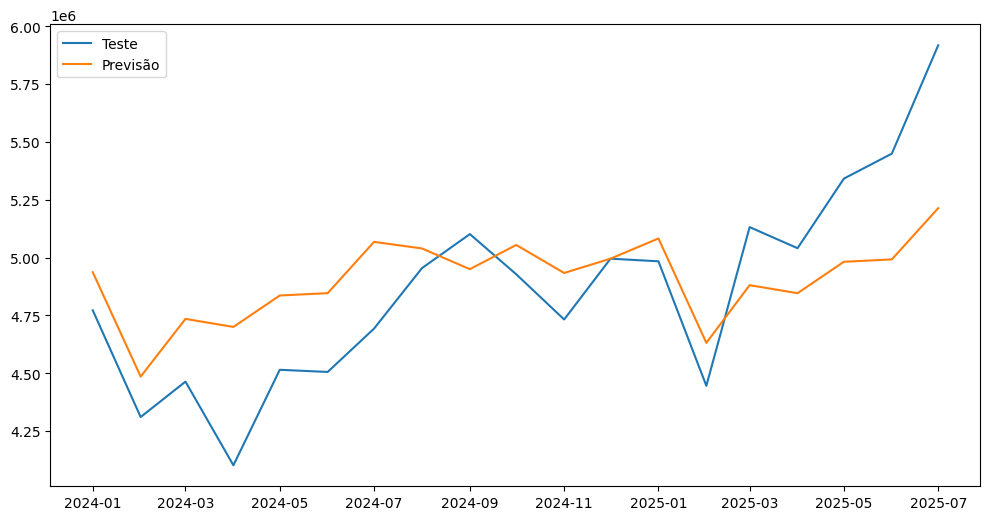

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Teste')
plt.plot(test.index, forecast_test, label='Previsão')
plt.legend()
plt.show()

In [28]:
print(final_model_holtwinters.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 producao   No. Observations:                  324
Model:             ExponentialSmoothing   SSE                  2831248449800.372
Optimized:                         True   AIC                           7448.682
Trend:                         Additive   BIC                           7509.174
Seasonal:                      Additive   AICC                          7450.925
Seasonal Periods:                    12   Date:                 Wed, 24 Sep 2025
Box-Cox:                          False   Time:                         00:01:08
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.5099168                alpha                 True
smoothing_trend          